MATH628  
Group 4

# Data Preprocessing

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from decimal import ROUND_HALF_UP, Decimal
import scipy.stats as si
from scipy import stats
from sklearn import preprocessing

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb

import warnings
warnings.filterwarnings('ignore')

## Stock data adjustment

In [2]:
origin_dir = r"D:\UMICH\Semester 2\MATH 628\final project\project\data"
my_dir = r"D:\UMICH\Semester 2\MATH 628\final project\project\data\train_files"

In [3]:
stock_df = pd.read_csv(os.path.join(my_dir, 'stock_prices.csv'), parse_dates=["Date"])

In [4]:
def adjust_price(price):
    """reference: https://www.kaggle.com/code/metathesis/feature-engineering-training-with-ta/notebook#Introduction-of-features-using-stock-price-data"""
    # set date to standard format
    price.loc[: ,"Date"] = pd.to_datetime(price.loc[: ,"Date"], format="%Y-%m-%d")
    
    def generate_adjusted_close(df):
        df = df.sort_values("Date", ascending=False)
        # generate CumulativeAdjustmentFactor
        df.loc[:, "CumulativeAdjustmentFactor"] = df["AdjustmentFactor"].cumprod()
        # generate AdjustedClose
        df.loc[:, "AdjustedClose"] = (
            df["CumulativeAdjustmentFactor"] * df["Close"]
        ).map(lambda x: float(
            Decimal(str(x)).quantize(Decimal('0.1'), rounding=ROUND_HALF_UP)
        ))
        # reverse order
        df = df.sort_values("Date")
        # to fill AdjustedClose, replace 0 into np.nan
        df.loc[df["AdjustedClose"] == 0, "AdjustedClose"] = np.nan
        # forward fill AdjustedClose
        df.loc[:, "AdjustedClose"] = df.loc[:, "AdjustedClose"].ffill()
        return df

    # generate AdjustedClose
    price = price.sort_values(["SecuritiesCode", "Date"])
    price = price.groupby("SecuritiesCode").apply(generate_adjusted_close).reset_index(drop=True)
    
    price.set_index("Date", inplace=True)
    return price

In [5]:
stock_df = adjust_price(stock_df)
stock_df.drop(columns=["AdjustmentFactor", "ExpectedDividend", "SupervisionFlag", "CumulativeAdjustmentFactor"], inplace=True)

In [6]:
stock_df.head()

,RowId,SecuritiesCode,Open,High,Low,Close,Volume,Target,AdjustedClose
Date,,,,,,,,,
2017-01-04,20170104_1301,1301,2734.0,2755.0,2730.0,2742.0,31400,0.000730,2742.0
2017-01-05,20170105_1301,1301,2743.0,2747.0,2735.0,2738.0,17900,0.002920,2738.0
2017-01-06,20170106_1301,1301,2734.0,2744.0,2720.0,2740.0,19900,-0.001092,2740.0
2017-01-10,20170110_1301,1301,2745.0,2754.0,2735.0,2748.0,24200,-0.005100,2748.0
2017-01-11,20170111_1301,1301,2748.0,2752.0,2737.0,2745.0,9300,-0.003295,2745.0


## Option data

In [ ]:
options_df = pd.read_csv(os.path.join(my_dir, 'options.csv'), parse_dates=["Date"])

In [ ]:
options_df.head()

In [ ]:
options_df.columns

### Underlying asset
Choose 1321 in the secondary stock price file as our underlying asset prices.

In [ ]:
underlying_etf = pd.read_csv(os.path.join(my_dir, 'secondary_stock_prices.csv'))
underlying_etf = underlying_etf[underlying_etf.SecuritiesCode.isin([1321])]
underlying_etf = adjust_price(underlying_etf)
underlying_etf.drop(columns=["AdjustmentFactor", "ExpectedDividend", "SupervisionFlag", "CumulativeAdjustmentFactor"], inplace=True)

In [ ]:
underlying_etf.head()

# Feature Engineering

## Stock features

In [ ]:
feats_stock = pd.DataFrame(stock_df[["SecuritiesCode", "Target"]], index=stock_df.index)

### Momentum factors

In [ ]:
feats_stock["return_10d"] = stock_df[["SecuritiesCode", "AdjustedClose"]].groupby(["SecuritiesCode"]).pct_change(10)
feats_stock["return_60d"] = stock_df[["SecuritiesCode", "AdjustedClose"]].groupby(["SecuritiesCode"]).pct_change(60)
feats_stock["return_70d"] = stock_df[["SecuritiesCode", "AdjustedClose"]].groupby(["SecuritiesCode"]).pct_change(70)
feats_stock["return_90d"] = stock_df[["SecuritiesCode", "AdjustedClose"]].groupby(["SecuritiesCode"]).pct_change(90)

In [ ]:
feats_stock["MA_10d"] = stock_df["AdjustedClose"] / stock_df[["SecuritiesCode", "AdjustedClose"]].groupby(["SecuritiesCode"], as_index=False).rolling(10).mean()["AdjustedClose"]
feats_stock["MA_40d"] = stock_df["AdjustedClose"] / stock_df[["SecuritiesCode", "AdjustedClose"]].groupby(["SecuritiesCode"], as_index=False).rolling(40).mean()["AdjustedClose"]
feats_stock["MA_50d"] = stock_df["AdjustedClose"] / stock_df[["SecuritiesCode", "AdjustedClose"]].groupby(["SecuritiesCode"], as_index=False).rolling(50).mean()["AdjustedClose"]
feats_stock["MA_90d"] = stock_df["AdjustedClose"] / stock_df[["SecuritiesCode", "AdjustedClose"]].groupby(["SecuritiesCode"], as_index=False).rolling(90).mean()["AdjustedClose"]

### Volatility factors

In [ ]:
feats_stock["volatility_20d"] = np.log(stock_df[["SecuritiesCode", "AdjustedClose"]]).groupby(["SecuritiesCode"], as_index=False)["AdjustedClose"].diff().rolling(20).std()
feats_stock["volatility_50d"] = np.log(stock_df[["SecuritiesCode", "AdjustedClose"]]).groupby(["SecuritiesCode"], as_index=False)["AdjustedClose"].diff().rolling(50).std()
feats_stock["volatility_60d"] = np.log(stock_df[["SecuritiesCode", "AdjustedClose"]]).groupby(["SecuritiesCode"], as_index=False)["AdjustedClose"].diff().rolling(60).std()
feats_stock["volatility_80d"] = np.log(stock_df[["SecuritiesCode", "AdjustedClose"]]).groupby(["SecuritiesCode"], as_index=False)["AdjustedClose"].diff().rolling(80).std()

In [ ]:
feats_stock.tail()

## Option features

In [ ]:
feats_option = pd.DataFrame(index=stock_df.index).reset_index().groupby(["Date"]).mean()

### Moneyness Factor

In [ ]:
strike_price = pd.merge(options_df.set_index("Date")[["Putcall", "StrikePrice"]], underlying_etf["AdjustedClose"], right_index=True, left_index=True)
strike_price["Putcall"] = strike_price["Putcall"].apply(lambda x: -1 if x==1 else 1)
strike_price["moneyness"] = (strike_price["Putcall"] * (strike_price["AdjustedClose"]-strike_price["StrikePrice"])) > 0

In [ ]:
feats_option["moneyness"] = strike_price.reset_index()[["Date", "moneyness"]].groupby(["Date"]).mean()

### StrikeVolatility Factor

In [ ]:
options_df.loc[: ,"LastTradingDay"] = pd.to_datetime(options_df.loc[: ,"LastTradingDay"], format="%Y%m%d")
options_df["ExpireDays"] = (options_df["LastTradingDay"] - options_df["Date"]).apply(lambda x: x.days)

In [ ]:
std_strike = options_df.reset_index()[["Date", "StrikePrice", "ExpireDays", "InterestRate"]]
# we should discount strike price K here
std_strike["DiscountedStrike"] = std_strike["StrikePrice"] * np.exp(-std_strike["InterestRate"]*std_strike["ExpireDays"])

In [ ]:
feats_option["strike_vol"] = std_strike[["Date", "DiscountedStrike"]].groupby(["Date"]).std()

### Liquidity Factor

In [ ]:
liquidity = options_df["SettlementPrice"] - options_df["TheoreticalPrice"]
liquidity = pd.concat([options_df["Date"], pd.DataFrame(liquidity, columns=["liquidity"])], axis=1)
feats_option["liquidity"] = liquidity.groupby(["Date"]).mean()

### Volatility Factor

In [ ]:
feats_option["historical_vol"] = options_df[["Date", "BaseVolatility"]].groupby(["Date"]).mean()

In [ ]:
feats_option["implied_vol"] = options_df[["Date", "ImpliedVolatility"]].groupby(["Date"]).mean()

### ImpliedVol Skewness Factor

In [ ]:
implied_vol = pd.merge(options_df.set_index("Date")[["Putcall", "StrikePrice", "ImpliedVolatility"]], underlying_etf["AdjustedClose"], right_index=True, left_index=True)
implied_vol["Putcall"] = implied_vol["Putcall"].apply(lambda x: -1 if x==1 else 1)
implied_vol_otm_call = implied_vol.apply(lambda x: x[2] if (x[0]==1 and x[3]<x[1]) else 0, axis=1)
implied_vol_otm_put = implied_vol.apply(lambda x: x[2] if (x[0]==-1 and x[3]>x[1]) else 0, axis=1)

In [ ]:
feats_option["implied_vol_skewness"] = implied_vol_otm_call.reset_index().groupby(["Date"]).mean() / implied_vol_otm_put.reset_index().groupby(["Date"]).mean()

### Trading Volume Factor

In [ ]:
trading_volume = options_df[['Date', 'Putcall', 'TradingVolume']].groupby(['Date', 'Putcall']).sum().unstack()
trading_volume = trading_volume["TradingVolume"]
trading_volume.rename(columns={1: "Put", 2: "Call"}, inplace=True)

In [ ]:
feats_option["trading_volume"] = trading_volume["Put"] + trading_volume["Call"]

### Put Call Ratio Factor

In [ ]:
feats_option["putcall_ratio"] = trading_volume["Put"] / trading_volume["Call"]

### BS model Greeks Factor 

In [ ]:
def d(s, k, r, T, sigma):
    d1 = (np.log(s/k) + (r+0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return (d1, d2)

def delta(s, k, r, T, sigma, putcall):
    # putcall==-1: put; putcall==1: call
    (d1, d2) = d(s, k, r, T, sigma)
    delta = putcall * si.norm.cdf(putcall*d1)
    delta.rename("delta", inplace=True)
    return delta

def gamma(s, k, r, T, sigma):
    (d1, d2) = d(s, k, r, T, sigma)
    gamma = si.norm.pdf(d1) / (s*sigma*np.sqrt(T))
    gamma.rename("gamma", inplace=True)
    return gamma

def vega(s, k, r, T, sigma):
    (d1, d2) = d(s, k, r, T, sigma)
    vega = (s*si.norm.pdf(d1) * np.sqrt(T))
    vega.rename("vega", inplace=True)
    return vega

def theta(s, k, r, T, sigma, putcall):
    (d1, d2) = d(s, k, r, T, sigma)
    theta = (-1*(s*si.norm.pdf(d1)*sigma) / (2*np.sqrt(T)) - putcall*r*k*np.exp(-r*T)*si.norm.cdf(putcall*d2)) / 365
    theta.rename("theta", inplace=True)
    return theta

In [ ]:
bs_params = pd.merge(options_df.set_index("Date")[["Putcall", "StrikePrice", "BaseVolatility", "ImpliedVolatility", "InterestRate", "ExpireDays"]], underlying_etf["AdjustedClose"], right_index=True, left_index=True)
bs_params["Putcall"] = bs_params["Putcall"].apply(lambda x: -1 if x==1 else 1)
s = bs_params["AdjustedClose"]
k = bs_params["StrikePrice"]
r = bs_params["InterestRate"]
T = bs_params["ExpireDays"]
sigma = bs_params["ImpliedVolatility"]
putcall = bs_params["Putcall"]

In [ ]:
options_delta = delta(s, k, r, T, sigma, putcall)
feats_option["delta"] = options_delta.reset_index().groupby(["Date"]).mean()

In [ ]:
options_theta = theta(s, k, r, T, sigma, putcall)
feats_option["theta"] = options_theta.reset_index().groupby(["Date"]).mean()

In [ ]:
options_gamma = gamma(s, k, r, T, sigma)
feats_option["gamma"] = options_gamma.reset_index().groupby(["Date"]).mean()

In [ ]:
options_vega = vega(s, k, r, T, sigma)
feats_option["vega"] = options_vega.reset_index().groupby(["Date"]).mean()

### Open Interest Factor

In [ ]:
feats_option["open_interest"] = options_df[["Date", "OpenInterest"]].groupby("Date").mean()

## Financials features

In [ ]:
financials_df = pd.read_csv(os.path.join(my_dir, 'financials.csv'), parse_dates=["Date"])

financials_df.drop(np.where(financials_df["SecuritiesCode"].isna())[0], inplace=True)
financials_df.loc[: ,"Date"] = pd.to_datetime(financials_df.loc[: ,"Date"], format="%Y-%m-%d")
financials_df["SecuritiesCode"] = financials_df["SecuritiesCode"].apply(lambda x: int(x))
financials_df.rename(columns={"DateCode": "RowId"}, inplace=True)
financials_df = financials_df[financials_df.SecuritiesCode.isin(stock_df.SecuritiesCode)]
financials_df.drop_duplicates(subset=["RowId"], inplace=True)

financials_df.head()

In [ ]:
financials_df = pd.merge(stock_df.reset_index(), 
             financials_df[["RowId", "DisclosedDate", "MaterialChangesInSubsidiaries", 
                            "ChangesOtherThanOnesBasedOnRevisionsOfAccountingStandard", "ChangesBasedOnRevisionsOfAccountingStandard", 
                            "ChangesInAccountingEstimates"]], 
             on=["RowId"], how="left")
financials_df.head()

In [ ]:
financials_df["MaterialChangesInSubsidiaries"] = financials_df["MaterialChangesInSubsidiaries"].apply(lambda x: 1 if x==True else -1 if x==False else 0)
financials_df["is_sub_changed"] = financials_df["MaterialChangesInSubsidiaries"] + \
                                  financials_df.groupby(["SecuritiesCode"])["MaterialChangesInSubsidiaries"].shift(1).fillna(0) + \
                                  financials_df.groupby(["SecuritiesCode"])["MaterialChangesInSubsidiaries"].shift(2).fillna(0)

In [ ]:
financials_df["ChangesBasedOnRevisionsOfAccountingStandard"] = financials_df["ChangesBasedOnRevisionsOfAccountingStandard"].apply(lambda x: 1 if x==True else -1 if x==False else 0)
financials_df["is_acc_changed"] = financials_df["ChangesBasedOnRevisionsOfAccountingStandard"] + \
                                  financials_df.groupby(["SecuritiesCode"])["ChangesBasedOnRevisionsOfAccountingStandard"].shift(1).fillna(0) + \
                                  financials_df.groupby(["SecuritiesCode"])["ChangesBasedOnRevisionsOfAccountingStandard"].shift(2).fillna(0)

In [ ]:
financials_df["ChangesOtherThanOnesBasedOnRevisionsOfAccountingStandard"] = financials_df["ChangesOtherThanOnesBasedOnRevisionsOfAccountingStandard"].apply(lambda x: 1 if x==True else -1 if x==False else 0)
financials_df["is_acc_other_changed"] = financials_df["ChangesOtherThanOnesBasedOnRevisionsOfAccountingStandard"] + \
                                        financials_df.groupby(["SecuritiesCode"])["ChangesOtherThanOnesBasedOnRevisionsOfAccountingStandard"].shift(1).fillna(0) + \
                                        financials_df.groupby(["SecuritiesCode"])["ChangesOtherThanOnesBasedOnRevisionsOfAccountingStandard"].shift(2).fillna(0)

In [ ]:
financials_df["ChangesInAccountingEstimates"] = financials_df["ChangesInAccountingEstimates"].apply(lambda x: 1 if x==True else -1 if x==False else 0)
financials_df["is_acc_est"] = financials_df["ChangesInAccountingEstimates"] + \
                              financials_df.groupby(["SecuritiesCode"])["ChangesInAccountingEstimates"].shift(1).fillna(0) + \
                              financials_df.groupby(["SecuritiesCode"])["ChangesInAccountingEstimates"].shift(2).fillna(0)

In [ ]:
financials_df = financials_df[["Date", "RowId", "SecuritiesCode", "is_sub_changed", "is_acc_changed", "is_acc_other_changed", "is_acc_est"]]

In [ ]:
financials_df.set_index("Date", inplace=True)

In [ ]:
# financials_df.to_csv("financials_df.csv")

## Feature Concatenate

In [78]:
feats = pd.merge(feats_stock, feats_option, right_index=True, left_index=True)

In [81]:
# feats.to_csv("feats.csv")

In [2]:
# feats = pd.read_csv("feats.csv")
# financials_df = pd.read_csv("financials_df.csv")

In [3]:
feats["is_acc_other_changed"] = financials_df["is_acc_other_changed"].values
feats["is_sub_changed"] = financials_df["is_sub_changed"].values
feats["is_acc_changed"] = financials_df["is_acc_changed"].values
feats["is_acc_est"] = financials_df["is_acc_est"].values

In [4]:
# feats.set_index("Date", inplace=True)

In [5]:
feats.tail()

,SecuritiesCode,Target,return_10d,return_60d,return_70d,return_90d,MA_10d,MA_40d,MA_50d,MA_90d,...,putcall_ratio,gamma,vega,delta,theta,open_interest,is_acc_other_changed,is_sub_changed,is_acc_changed,is_acc_est
Date,,,,,,,,,,,,,,,,,,,,,
2021-12-03,9990,0.034816,-0.067138,-0.052065,-0.020408,-0.128713,0.981778,0.937375,0.936104,0.935249,...,1.608986,2.969274e-08,149.319338,0.498729,-0.032637,350.479947,0.0,0.0,0.0,0.0
2021-12-03,9991,0.025478,0.002525,-0.119734,-0.092571,-0.105856,1.004809,0.947353,0.935747,0.915896,...,1.608986,2.969274e-08,149.319338,0.498729,-0.032637,350.479947,0.0,0.0,0.0,0.0
2021-12-03,9993,-0.004302,-0.044715,-0.056225,-0.058924,-0.035191,0.972452,0.962284,0.959150,0.953224,...,1.608986,2.969274e-08,149.319338,0.498729,-0.032637,350.479947,0.0,0.0,0.0,0.0
2021-12-03,9994,0.009098,-0.006653,-0.054236,0.000000,0.035544,1.005471,0.993688,0.987345,0.983978,...,1.608986,2.969274e-08,149.319338,0.498729,-0.032637,350.479947,0.0,0.0,0.0,0.0
2021-12-03,9997,0.018414,-0.027933,-0.195376,-0.112245,-0.242655,1.005054,0.907994,0.890914,0.856229,...,1.608986,2.969274e-08,149.319338,0.498729,-0.032637,350.479947,0.0,0.0,0.0,0.0


In [86]:
del options_df
del stock_df
del financials_df
del underlying_etf

# Dataset
2017-2020 as train data, 2021 as validation data, test file from 2021-12-06 to 2022-06-22 as test data.

## Train and val of all features

In [6]:
trainval_dataset = feats.drop(["SecuritiesCode"], axis=1).dropna()
features = list(trainval_dataset.columns)
features.remove('Target')

x_trainval = trainval_dataset[features]
y_trainval = trainval_dataset["Target"]

In [7]:
scaler = preprocessing.StandardScaler()
x_trainval = scaler.fit_transform(x_trainval)

In [8]:
x_train = x_trainval[:1768537]  # 2017-03-31 : 2020-12-31
y_train = y_trainval.values[:1768537]
x_val = x_trainval[1768537:]  # 2021-01-01 : 2021-12-04
y_val = y_trainval.values[1768537:]

In [9]:
features

['return_10d',
 'return_60d',
 'return_70d',
 'return_90d',
 'MA_10d',
 'MA_40d',
 'MA_50d',
 'MA_90d',
 'volatility_20d',
 'volatility_50d',
 'volatility_60d',
 'volatility_80d',
 'moneyness',
 'strike_vol',
 'liquidity',
 'historical_vol',
 'implied_vol',
 'implied_vol_skewness',
 'trading_volume',
 'putcall_ratio',
 'gamma',
 'vega',
 'delta',
 'theta',
 'open_interest',
 'is_acc_other_changed',
 'is_sub_changed',
 'is_acc_changed',
 'is_acc_est']

We have 29 features now.

## Train and Val of stock features

In [24]:
features_stock = list(features[:12])

x_stock_trainval = trainval_dataset[features_stock]
y_stock_trainval = trainval_dataset["Target"]

In [25]:
scaler_stock = preprocessing.StandardScaler()
x_stock_trainval = scaler_stock.fit_transform(x_stock_trainval)

x_stock_train = x_stock_trainval[:1768537]  # 2017-03-31 : 2020-12-31
y_stock_train = y_stock_trainval.values[:1768537]
x_stock_val = x_stock_trainval[1768537:]  # 2021-01-01 : 2021-12-04
y_stock_val = y_stock_trainval.values[1768537:]

In [26]:
features_stock

['return_10d',
 'return_60d',
 'return_70d',
 'return_90d',
 'MA_10d',
 'MA_40d',
 'MA_50d',
 'MA_90d',
 'volatility_20d',
 'volatility_50d',
 'volatility_60d',
 'volatility_80d']

## Train and Val of option features

In [27]:
features_option = list(features[12:-4])

x_option_trainval = trainval_dataset[features_option]
y_option_trainval = trainval_dataset["Target"]

scaler_option = preprocessing.StandardScaler()
x_option_trainval = scaler_option.fit_transform(x_option_trainval)

x_option_train = x_option_trainval[:1768537]  # 2017-03-31 : 2020-12-31
y_option_train = y_option_trainval.values[:1768537]
x_option_val = x_option_trainval[1768537:]  # 2021-01-01 : 2021-12-04
y_option_val = y_option_trainval.values[1768537:]

features_option

['moneyness',
 'strike_vol',
 'liquidity',
 'historical_vol',
 'implied_vol',
 'implied_vol_skewness',
 'trading_volume',
 'putcall_ratio',
 'gamma',
 'vega',
 'delta',
 'theta',
 'open_interest']

## Train and Val of stock and option features

In [29]:
features_so = list(features[:-4])

x_so_trainval = trainval_dataset[features_so]
y_so_trainval = trainval_dataset["Target"]

scaler_so = preprocessing.StandardScaler()
x_so_trainval = scaler_so.fit_transform(x_so_trainval)

x_so_train = x_so_trainval[:1768537]  # 2017-03-31 : 2020-12-31
y_so_train = y_so_trainval.values[:1768537]
x_so_val = x_so_trainval[1768537:]  # 2021-01-01 : 2021-12-04
y_so_val = y_so_trainval.values[1768537:]

features_so

['return_10d',
 'return_60d',
 'return_70d',
 'return_90d',
 'MA_10d',
 'MA_40d',
 'MA_50d',
 'MA_90d',
 'volatility_20d',
 'volatility_50d',
 'volatility_60d',
 'volatility_80d',
 'moneyness',
 'strike_vol',
 'liquidity',
 'historical_vol',
 'implied_vol',
 'implied_vol_skewness',
 'trading_volume',
 'putcall_ratio',
 'gamma',
 'vega',
 'delta',
 'theta',
 'open_interest']

# Model

## LightGBM

In [22]:
def plot_importance(importances, features_names=features, PLOT_TOP_N=10, figsize=(10, 10)):
    importance_df = pd.DataFrame(data=importances, columns=features_names)
    sorted_indices = importance_df.median(axis=0).sort_values(ascending=False).index
    sorted_importance_df = importance_df.loc[:, sorted_indices]
    plot_cols = sorted_importance_df.columns[:PLOT_TOP_N]
    _, ax = plt.subplots(figsize=figsize)
    ax.grid()
    ax.set_xscale('log')
    ax.set_ylabel('Feature')
    ax.set_xlabel('Importance')
    sns.boxplot(data=sorted_importance_df[plot_cols],
                orient='h',
                ax=ax)
    plt.show()

In [33]:
def feval_corr(y_pred, lgb_train):
    y_true = lgb_train.get_label()
    return 'corr', np.abs(stats.pearsonr(y_true, y_pred)[0]), True

### Train by all features

In [12]:
tr_dataset = lgb.Dataset(x_train, y_train, feature_name=features)
vl_dataset = lgb.Dataset(x_val, y_val, feature_name=features)

In [19]:
params_lgb = {'learning_rate': 0.01,
              'metric': 'None',
              'objective': 'regression',
              'boosting': 'gbdt',
              'verbosity': 0,
              'n_jobs': -1,
              'force_col_wise':True}  

In [20]:
model = lgb.train(params=params_lgb,
                  train_set=tr_dataset,
                  valid_sets=[tr_dataset, vl_dataset],
                  valid_names=['train', 'validation'],
                  num_boost_round=5000,
                  verbose_eval=100,
                  feval=feval_corr,
                  callbacks=[lgb.early_stopping(stopping_rounds=300, verbose=True), lgb.log_evaluation(period=25)])

Training until validation scores don't improve for 300 rounds
[25]	train's corr: 0.341582	validation's corr: 0.0132439
[50]	train's corr: 0.3518	validation's corr: 0.0147995
[75]	train's corr: 0.364026	validation's corr: 0.0148046
[100]	train's corr: 0.377332	validation's corr: 0.0160062
[100]	train's corr: 0.377332	validation's corr: 0.0160062
[125]	train's corr: 0.388658	validation's corr: 0.0224575
[150]	train's corr: 0.399221	validation's corr: 0.0227257
[175]	train's corr: 0.408029	validation's corr: 0.0312898
[200]	train's corr: 0.416125	validation's corr: 0.033919
[200]	train's corr: 0.416125	validation's corr: 0.033919
[225]	train's corr: 0.424519	validation's corr: 0.0320467
[250]	train's corr: 0.431628	validation's corr: 0.0362485
[275]	train's corr: 0.438094	validation's corr: 0.0422234
[300]	train's corr: 0.443128	validation's corr: 0.0483369
[300]	train's corr: 0.443128	validation's corr: 0.0483369
[325]	train's corr: 0.448636	validation's corr: 0.0487231
[350]	train's cor

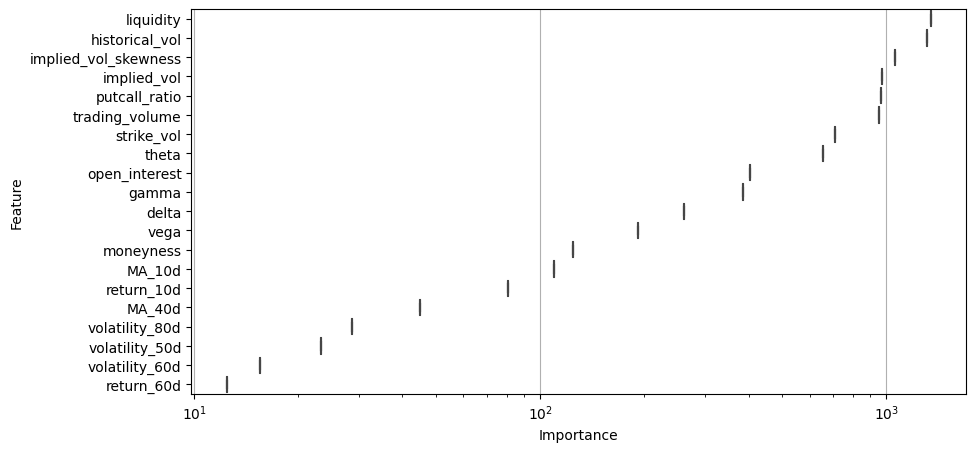

In [23]:
importance = [model.feature_importance(importance_type='gain')]
plot_importance(np.array(importance), features, PLOT_TOP_N=20, figsize=(10, 5))

### Train by stock features

In [30]:
tr_dataset = lgb.Dataset(x_stock_train, y_stock_train, feature_name=features_stock)
vl_dataset = lgb.Dataset(x_stock_val, y_stock_val, feature_name=features_stock)

In [31]:
params_lgb = {'learning_rate': 0.01,
              'metric': 'None',
              'objective': 'regression',
              'boosting': 'gbdt',
              'verbosity': 0,
              'n_jobs': -1,
              'force_col_wise':True}  

In [34]:
model = lgb.train(params=params_lgb,
                  train_set=tr_dataset,
                  valid_sets=[tr_dataset, vl_dataset],
                  valid_names=['train', 'validation'],
                  num_boost_round=5000,
                  verbose_eval=100,
                  feval=feval_corr,
                  callbacks=[lgb.early_stopping(stopping_rounds=300, verbose=True), lgb.log_evaluation(period=25)])

Training until validation scores don't improve for 300 rounds
[25]	train's corr: 0.0948794	validation's corr: 0.00464056
[50]	train's corr: 0.102537	validation's corr: 0.00549034
[75]	train's corr: 0.106647	validation's corr: 0.00575782
[100]	train's corr: 0.110501	validation's corr: 0.00664953
[100]	train's corr: 0.110501	validation's corr: 0.00664953
[125]	train's corr: 0.11406	validation's corr: 0.00712884
[150]	train's corr: 0.118759	validation's corr: 0.0079138
[175]	train's corr: 0.122779	validation's corr: 0.00874987
[200]	train's corr: 0.125755	validation's corr: 0.00921271
[200]	train's corr: 0.125755	validation's corr: 0.00921271
[225]	train's corr: 0.128108	validation's corr: 0.00956738
[250]	train's corr: 0.130066	validation's corr: 0.0098316
[275]	train's corr: 0.131788	validation's corr: 0.0100495
[300]	train's corr: 0.133651	validation's corr: 0.0103048
[300]	train's corr: 0.133651	validation's corr: 0.0103048
[325]	train's corr: 0.135428	validation's corr: 0.0104886
[35

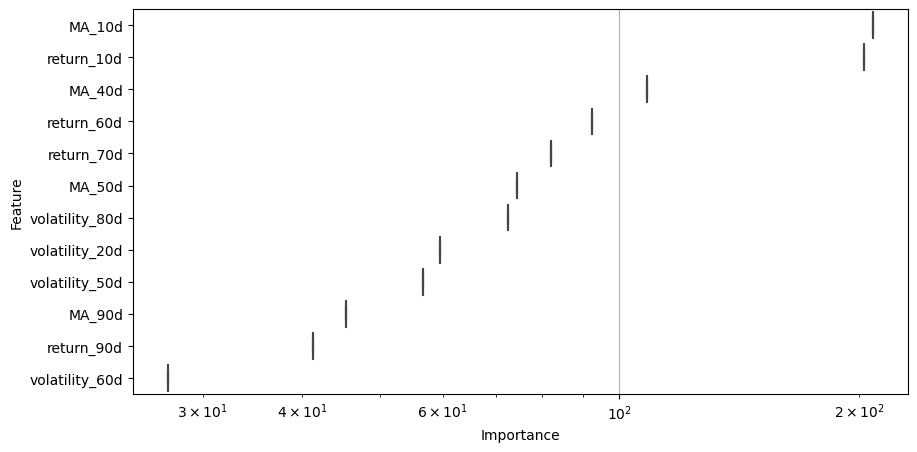

In [36]:
importance = [model.feature_importance(importance_type='gain')]
plot_importance(np.array(importance), features_stock, PLOT_TOP_N=20, figsize=(10, 5))

### Train by option features

In [37]:
tr_dataset = lgb.Dataset(x_option_train, y_option_train, feature_name=features_option)
vl_dataset = lgb.Dataset(x_option_val, y_option_val, feature_name=features_option)

In [38]:
params_lgb = {'learning_rate': 0.01,
              'metric': 'None',
              'objective': 'regression',
              'boosting': 'gbdt',
              'verbosity': 0,
              'n_jobs': -1,
              'force_col_wise':True}  

In [39]:
model = lgb.train(params=params_lgb,
                  train_set=tr_dataset,
                  valid_sets=[tr_dataset, vl_dataset],
                  valid_names=['train', 'validation'],
                  num_boost_round=5000,
                  verbose_eval=100,
                  feval=feval_corr,
                  callbacks=[lgb.early_stopping(stopping_rounds=300, verbose=True), lgb.log_evaluation(period=25)])

Training until validation scores don't improve for 300 rounds
[25]	train's corr: 0.3408	validation's corr: 0.0075832
[50]	train's corr: 0.351806	validation's corr: 0.00561168
[75]	train's corr: 0.364655	validation's corr: 0.0072343
[100]	train's corr: 0.379237	validation's corr: 0.0080316
[100]	train's corr: 0.379237	validation's corr: 0.0080316
[125]	train's corr: 0.388677	validation's corr: 0.0150427
[150]	train's corr: 0.3985	validation's corr: 0.0241002
[175]	train's corr: 0.407732	validation's corr: 0.0339291
[200]	train's corr: 0.41473	validation's corr: 0.0345158
[200]	train's corr: 0.41473	validation's corr: 0.0345158
[225]	train's corr: 0.422567	validation's corr: 0.0360889
[250]	train's corr: 0.429166	validation's corr: 0.0381578
[275]	train's corr: 0.434755	validation's corr: 0.042224
[300]	train's corr: 0.439483	validation's corr: 0.0433671
[300]	train's corr: 0.439483	validation's corr: 0.0433671
[325]	train's corr: 0.443925	validation's corr: 0.0469407
[350]	train's corr:

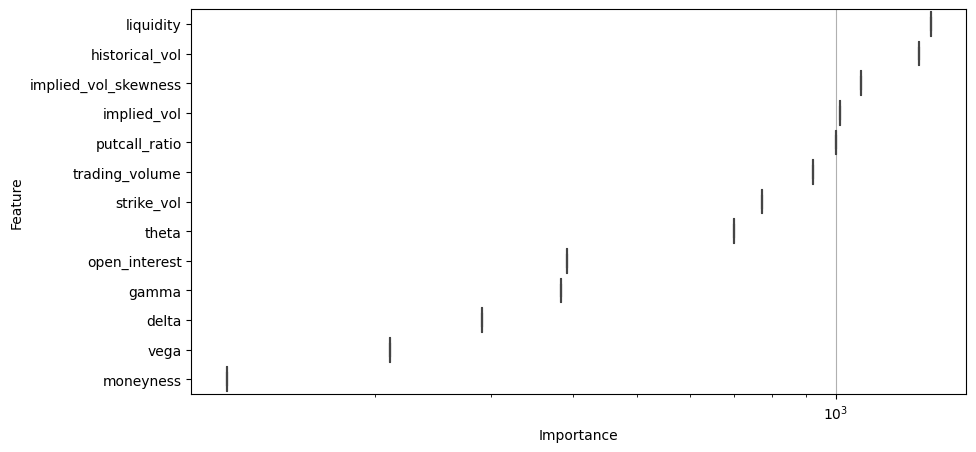

In [40]:
importance = [model.feature_importance(importance_type='gain')]
plot_importance(np.array(importance), features_option, PLOT_TOP_N=20, figsize=(10, 5))

## Train by stock and option features

In [41]:
tr_dataset = lgb.Dataset(x_so_train, y_so_train, feature_name=features_so)
vl_dataset = lgb.Dataset(x_so_val, y_so_val, feature_name=features_so)

In [42]:
params_lgb = {'learning_rate': 0.01,
              'metric': 'None',
              'objective': 'regression',
              'boosting': 'gbdt',
              'verbosity': 0,
              'n_jobs': -1,
              'force_col_wise':True}  

In [43]:
model = lgb.train(params=params_lgb,
                  train_set=tr_dataset,
                  valid_sets=[tr_dataset, vl_dataset],
                  valid_names=['train', 'validation'],
                  num_boost_round=5000,
                  verbose_eval=100,
                  feval=feval_corr,
                  callbacks=[lgb.early_stopping(stopping_rounds=300, verbose=True), lgb.log_evaluation(period=25)])

Training until validation scores don't improve for 300 rounds
[25]	train's corr: 0.341582	validation's corr: 0.0132439
[50]	train's corr: 0.3518	validation's corr: 0.0147995
[75]	train's corr: 0.364026	validation's corr: 0.0148046
[100]	train's corr: 0.377332	validation's corr: 0.0160062
[100]	train's corr: 0.377332	validation's corr: 0.0160062
[125]	train's corr: 0.388658	validation's corr: 0.0224575
[150]	train's corr: 0.399221	validation's corr: 0.0227257
[175]	train's corr: 0.408029	validation's corr: 0.0312898
[200]	train's corr: 0.416125	validation's corr: 0.033919
[200]	train's corr: 0.416125	validation's corr: 0.033919
[225]	train's corr: 0.424519	validation's corr: 0.0320467
[250]	train's corr: 0.431628	validation's corr: 0.0362485
[275]	train's corr: 0.438094	validation's corr: 0.0422234
[300]	train's corr: 0.443128	validation's corr: 0.0483369
[300]	train's corr: 0.443128	validation's corr: 0.0483369
[325]	train's corr: 0.448636	validation's corr: 0.0487231
[350]	train's cor

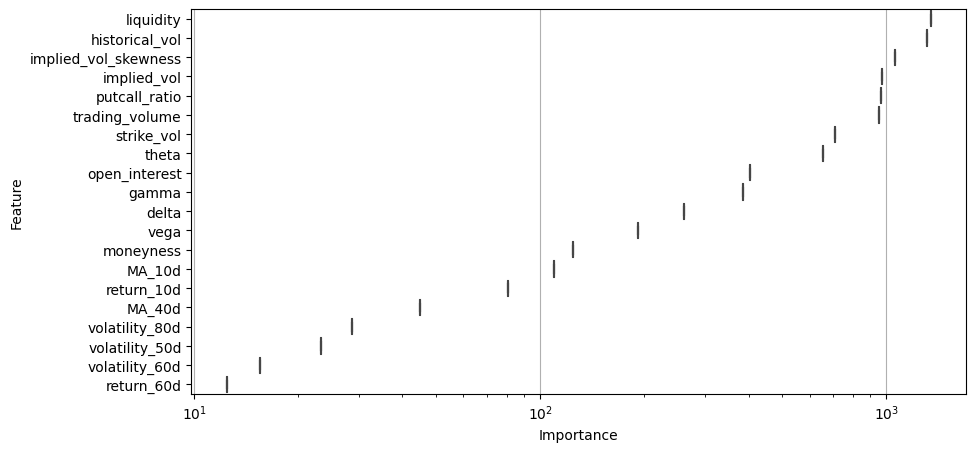

In [45]:
importance = [model.feature_importance(importance_type='gain')]
plot_importance(np.array(importance), features_so, PLOT_TOP_N=20, figsize=(10, 5))